In [1]:
import os
import pynwb
import h5py
from tqdm import tqdm
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import pywt
import matplotlib
import graph
import time
import pickle

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import gridspec

from scipy import signal
from scipy.fftpack import next_fast_len
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy.signal import filtfilt, hilbert, remez, sosfiltfilt, butter, find_peaks
import pingouin as pg
from scipy.stats import fisher_exact


import load_data
import LFP
import single_neuron_vis

In [24]:
ses_info = pd.DataFrame({
    'session': ['031723','032823','033123','032023','040423','040723','050824',
                '101124','100324','092124','092324','092524','100124','100924'],
    'animal': ['Bart']*7 + ['London']*7
})

# ses_info = pd.DataFrame({
#     'session': ['031723','032823','033123','032023','040423','040723'],
#     'animal': ['Bart']*6
# })
    
action_all = pd.DataFrame()

for _, row in ses_info.iterrows():
    date = row['session']
    animal = row['animal']

    nwbfile = load_data.load_nwbfile(animal, date)

    action_df = (
        nwbfile.intervals['action_on']
        .to_dataframe()
        .query('trialerror==0')
        .copy()
    )

    # add metadata (very important)
    action_df['session'] = date
    action_df['animal'] = animal

    action_all = pd.concat([action_all,action_df])

action_all = action_all.drop(columns=['timeseries'])

first = action_all.query('step==0').copy()
first['trial_in_block'] = (
    first
    .groupby(['session', 'block'])
    .cumcount()
)

block_targets = (
    first
    .drop_duplicates(subset=['session', 'block'])
    [['session', 'block', 'target']]
)

block_targets['prev_block_target'] = (
    block_targets
    .groupby('session')['target']
    .shift(1)
)

first = first.merge(
    block_targets[['session', 'block', 'prev_block_target']],
    on=['session', 'block'],
    how='left'
)

first['optimality'] = first['graph_distance']/first['nsteps']
first['extra'] = first['nsteps']-first['graph_distance']

In [28]:
first['steps_saved']=first['spatial_distance']-first['graph_distance']

In [50]:
tele_trials = []
tele_perf = []
for ss in ['031723','032823','033123','032023','040423','040723','050824','101124','100324','092124','092324','092524','100124','100924']:
    session = first[first.session==ss]
    tele_trials.append(np.sum(session.steps_saved==1))
    tele_perf.append(np.sum((session.steps_saved==1) & (session.extra>0)))

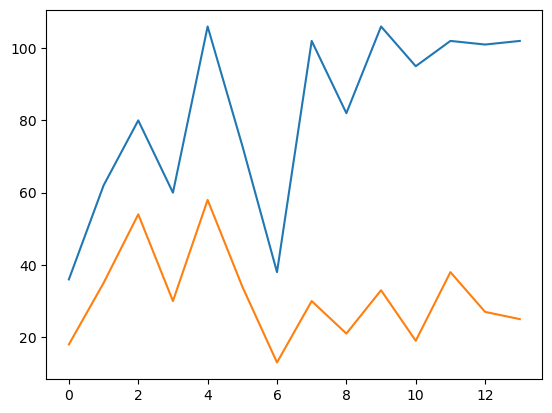

In [51]:
plt.plot(np.stack(tele_trials))
plt.plot(np.stack(tele_perf))

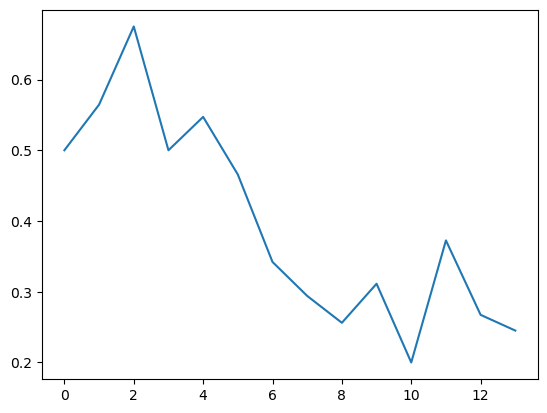

In [52]:
plt.plot(np.stack(tele_perf)/np.stack(tele_trials))

In [35]:
np.mean(first.query('steps_saved>0').extra==0)

np.float64(0.751263335204941)

In [34]:
first.query('steps_saved>0').groupby('extra').count()

,start_time,stop_time,trial,step,trialerror,nsteps,start,target,block,blocktrialnumber,...,spatial_distance,window_size,nodes,session,animal,jackpot,trial_in_block,prev_block_target,optimality,steps_saved
extra,,,,,,,,,,,,,,,,,,,,,
0.0,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,...,1338,1338,1338,1338,1338,951,1338,1322,1338,1338
1.0,385,385,385,385,385,385,385,385,385,385,...,385,385,385,385,385,186,385,376,385,385
2.0,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,10,20,20,20,20
3.0,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,10,22,21,22,22
4.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,0,2,2,2,2
5.0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
7.0,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,0,4,4,4,4
8.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
9.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1


In [27]:
first.groupby('extra').count()

,start_time,stop_time,trial,step,trialerror,nsteps,start,target,block,blocktrialnumber,...,graph_distance,spatial_distance,window_size,nodes,session,animal,jackpot,trial_in_block,prev_block_target,optimality
extra,,,,,,,,,,,,,,,,,,,,,
0.0,8303,8303,8303,8303,8303,8303,8303,8303,8303,8303,...,8303,8303,8303,8303,8303,8303,5045,8303,8225,8303
1.0,523,523,523,523,523,523,523,523,523,523,...,523,523,523,523,523,523,283,523,514,523
2.0,201,201,201,201,201,201,201,201,201,201,...,201,201,201,201,201,201,103,201,200,201
3.0,51,51,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,24,51,50,51
4.0,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,12,24,24,24
5.0,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,6,8,8,8
6.0,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,6,10,10,10
7.0,8,8,8,8,8,8,8,8,8,8,...,8,8,8,8,8,8,3,8,8,8
8.0,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,0,6,6,6


<Axes: xlabel='graph_distance', ylabel='extra'>

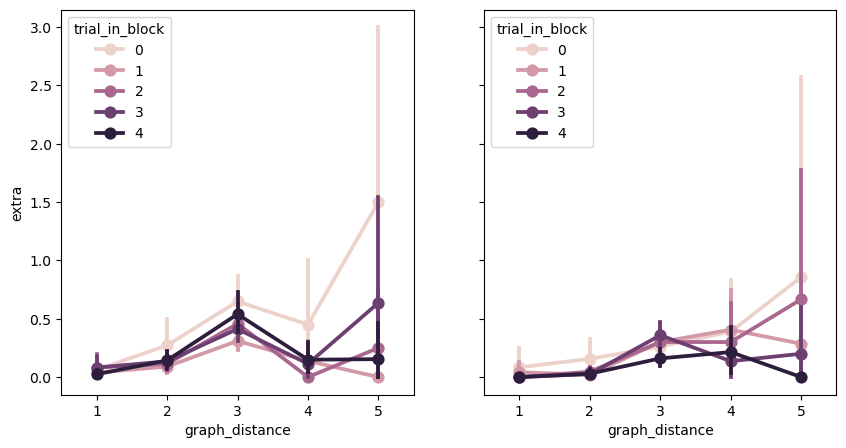

In [66]:
plt.close('all')
fig, axes = plt.subplots(1,2,figsize=(10,5),sharey=True)

animal = 'Bart'
sns.pointplot(data=first.query('(trial_in_block<5)&(animal==@animal)'),x='graph_distance',y='extra',hue='trial_in_block',ax=axes[0])

animal = 'London'
sns.pointplot(data=first.query('(trial_in_block<5)&(animal==@animal)'),x='graph_distance',y='extra',hue='trial_in_block',ax=axes[1])


<Axes: xlabel='trial_in_block', ylabel='extra'>

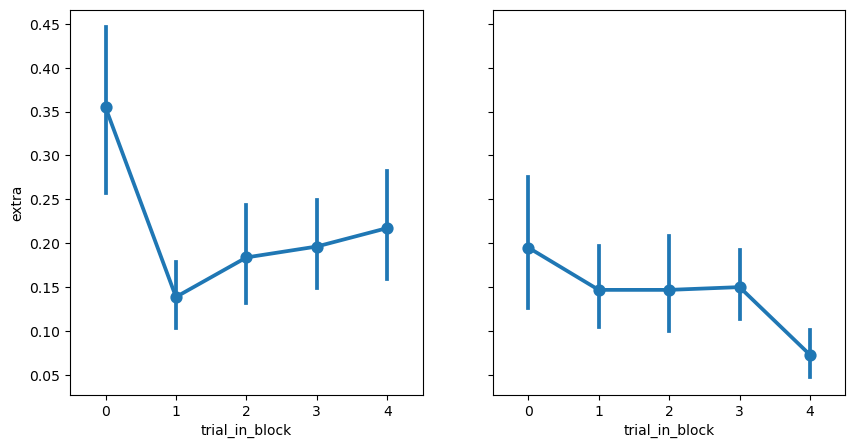

In [79]:
plt.close('all')
fig, axes = plt.subplots(1,2,figsize=(10,5),sharey=True)

animal = 'Bart'
sns.pointplot(data=first.query('(trial_in_block<5)&(animal==@animal)'),y='extra',x='trial_in_block',ax=axes[0])

animal = 'London'
sns.pointplot(data=first.query('(trial_in_block<5)&(animal==@animal)'),y='extra',x='trial_in_block',ax=axes[1])


<Axes: xlabel='graph_distance', ylabel='optimality'>

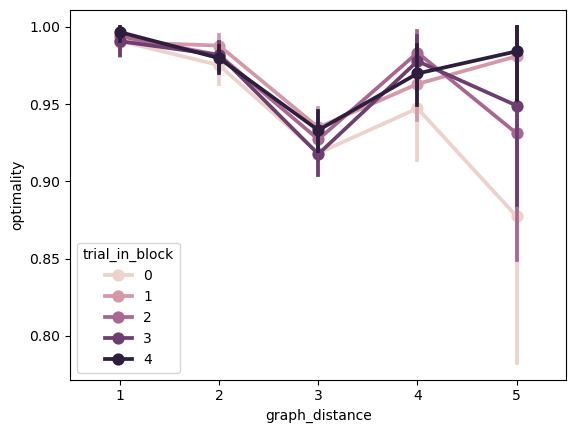

In [56]:
plt.close('all')
sns.pointplot(data=first.query('trial_in_block<5'),x='graph_distance',y='optimality',hue='trial_in_block')

In [21]:
first[(first.trial_in_block==0)].shape

(746, 22)

In [22]:
first.query('trial_in_block==0')

,start_time,stop_time,trial,step,trialerror,nsteps,start,target,block,blocktrialnumber,...,graph_distance,spatial_distance,window_size,nodes,session,animal,trial_in_block,prev_block_target,optimality,extra
0,28388.0,29388.0,2,0,0.0,3.0,9.0,7.0,1.0,3.0,...,3,3,500,"9,10,11,7",031723,Bart,0,NaN,1.0,0.0
5,120340.0,121340.0,9,0,0.0,1.0,10.0,14.0,2.0,3.0,...,1,1,500,"10,14",031723,Bart,0,7.0,1.0,0.0
10,227743.0,228743.0,16,0,0.0,1.0,9.0,8.0,3.0,3.0,...,1,1,500,"9,8",031723,Bart,0,14.0,1.0,0.0
15,275088.0,276088.0,23,0,0.0,4.0,9.0,1.0,4.0,3.0,...,2,2,500,"9,5,6,2,1",031723,Bart,0,8.0,0.5,2.0
20,312061.0,313061.0,30,0,0.0,1.0,6.0,7.0,5.0,3.0,...,1,1,500,"6,7",031723,Bart,0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3641,5014131.0,5015131.0,877,0,0.0,3.0,14.0,7.0,116.0,3.0,...,3,3,500,"14,10,11,7",040723,Bart,0,1.0,1.0,0.0
3646,5063571.0,5064571.0,887,0,0.0,1.0,13.0,14.0,117.0,3.0,...,1,1,500,"13,14",040723,Bart,0,7.0,1.0,0.0
3651,5108587.0,5109587.0,896,0,0.0,5.0,12.0,7.0,118.0,3.0,...,5,5,500,"12,13,14,15,11,7",040723,Bart,0,14.0,1.0,0.0
3656,5158316.0,5159316.0,904,0,0.0,2.0,15.0,1.0,119.0,3.0,...,2,5,500,"15,0,1",040723,Bart,0,7.0,1.0,0.0


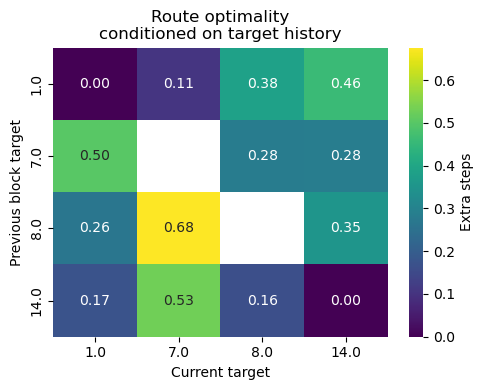

In [23]:
pivot = first[(first.trial_in_block==0)&(first.animal=='Bart')].pivot_table(
    index='prev_block_target',
    columns='target',
    values='extra',
    aggfunc='mean'
)

plt.figure(figsize=(5,4))

sns.heatmap(
    pivot,
    annot=True,
    fmt='.2f',
    cmap='viridis',
    cbar_kws={'label': 'Extra steps'}
)

plt.xlabel('Current target')
plt.ylabel('Previous block target')
plt.title('Route optimality\nconditioned on target history')
plt.tight_layout()


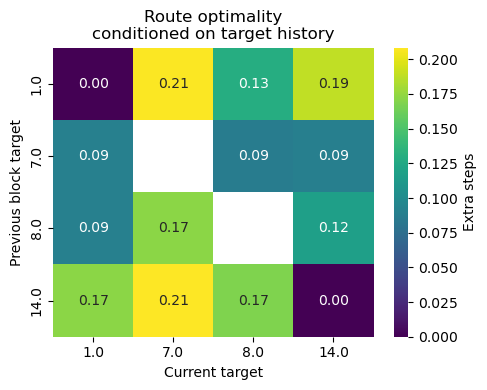

In [61]:
pivot = first.query('trial_in_block==1').pivot_table(
    index='prev_block_target',
    columns='target',
    values='extra',
    aggfunc='mean'
)

plt.figure(figsize=(5,4))

sns.heatmap(
    pivot,
    annot=True,
    fmt='.2f',
    cmap='viridis',
    cbar_kws={'label': 'Extra steps'}
)

plt.xlabel('Current target')
plt.ylabel('Previous block target')
plt.title('Route optimality\nconditioned on target history')
plt.tight_layout()


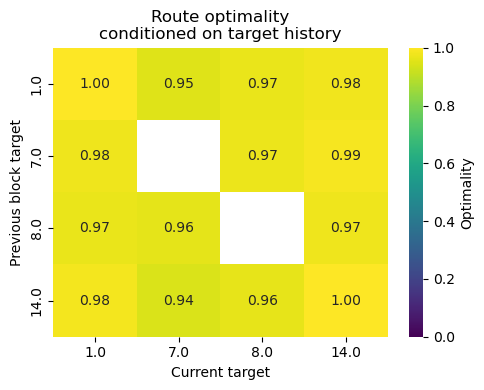

In [51]:
pivot = first.query('trial_in_block==2').pivot_table(
    index='prev_block_target',
    columns='target',
    values='optimality',
    aggfunc='mean'
)

plt.figure(figsize=(5,4))

sns.heatmap(
    pivot,
    annot=True,
    fmt='.2f',
    cmap='viridis',
    vmin=0, vmax=1,      # optimality is typically 0–1
    cbar_kws={'label': 'Optimality'}
)

plt.xlabel('Current target')
plt.ylabel('Previous block target')
plt.title('Route optimality\nconditioned on target history')
plt.tight_layout()
